In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import chardet as chardet
import requests
import os
import tiktoken
from bs4 import BeautifulSoup as Soup

from langchain_community.document_loaders import UnstructuredXMLLoader
from langchain_community.document_loaders import RecursiveUrlLoader

from langchain_community.document_loaders import PyPDFLoader
import json
from pathlib import Path

from langchain_core.tracers.context import tracing_v2_enabled
from scripts import calulate 
from scripts import print_pdf
from langchain_community.document_loaders import BSHTMLLoader

In [2]:
calulate.print_table("microsoft/Phi-3-mini-128k-instruct", bparams=3.8,  max_name="max_position_embeddings", mode="infer",precisions=[4,5,6,8,16])

    Model: microsoft/Phi-3-mini-128k-instruct
    Params: 3.8B
    Batch Size: 1
    Mode: infer
    
    Sequence Length vs Bit Precision - Memory Requirements
       SL / BP |     4      |     5      |     6      |     8      |     16    
    ---------------------------------------------------------------------------
           256 |      1.8GB |      2.2GB |      2.7GB |      3.6GB |      7.2GB
           512 |      1.8GB |      2.3GB |      2.7GB |      3.6GB |      7.3GB
          1024 |      1.9GB |      2.3GB |      2.8GB |      3.7GB |      7.5GB
          2048 |      2.0GB |      2.4GB |      2.9GB |      3.9GB |      7.8GB
          4096 |      2.1GB |      2.7GB |      3.2GB |      4.3GB |      8.6GB
          8192 |      2.5GB |      3.1GB |      3.8GB |      5.0GB |     10.1GB
         16384 |      3.3GB |      4.1GB |      4.9GB |      6.5GB |     13.1GB
         32768 |      4.8GB |      6.0GB |      7.2GB |      9.5GB |     19.1GB
         65536 |      7.8GB |      9.7G

In [ ]:
import os
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "pt-essential-legislator-78"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = "ls__270adeb98c1d4b79bd8ca3ef4673b843"  # Update to your API key

# Used by the agent in this tutorial

In [4]:
def get_encoding(file):
    with open(file, 'rb') as f:
        result = chardet.detect(f.read())
    return result['encoding']
file_path = 'C:/Users/Jens/data_sienc_visuel/data/Resultat2.csv'
encoding = get_encoding(file_path)
print(encoding)

utf-16le


In [ ]:
/set parameter num_ctx 

In [5]:
df = pd.read_csv(file_path, encoding=encoding, sep=';')
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57806 entries, 0 to 57805
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Rank                         57806 non-null  object 
 1   DokumentType                 57806 non-null  object 
 2   Titel                        57806 non-null  object 
 3   PopulærTitel                 1373 non-null   object 
 4   Ressort                      57806 non-null  object 
 5   AdministrerendeMyndighed     42568 non-null  object 
 6   JournalNummer                55179 non-null  object 
 7   Nummer                       57806 non-null  int64  
 8   År                           57806 non-null  int64  
 9   DokumentId                   57806 non-null  object 
 10  ACCN                         57806 non-null  object 
 11  Publiceringsmedie            57806 non-null  object 
 12  UndtagetFraOffentliggørelse  133 non-null    object 
 13  GeografiskDæknin

C:\Users\Jens\AppData\Local\Temp\ipykernel_26148\3808103124.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding, sep=';')


In [36]:
given_accn = 'A18421110019'
row = df.loc[df['ACCN'] == given_accn]
rank=row['AdministrerendeMyndighed']

rank_str = str(rank.values[0])
print(rank_str)



nan


In [ ]:
count = 0
file_paths = []
amount = 50
aliv=amount+1
##amount = len(df['EliUrl'])
##aliv=len(df['EliUrl'])

for entity in df['EliUrl']:
    response = requests.get(entity + "/xml")
    
    file_name = os.path.basename(df['ACCN'][count]) + ".xml"

    file_path = os.path.join("C:/Users/Jens/data_sienc_visuel/data/xml/", file_name)
    
    with open(file_path, 'wb') as f:
        f.write(response.content)    
    file_paths.append(file_path)    
    count += 1 
    if count > amount:
        break
            
with open('C:/Users/Jens/data_sienc_visuel/data/xml/path_list.txt', 'w') as f:
    for paths in file_paths:
        f.write(f"{paths}\n") 

In [ ]:
with open ('C:/Users/Jens/data_sienc_visuel/data/xml/path_list.txt', 'r') as f:
    file_paths = f.readlines()
    file_paths = [path.strip() for path in file_paths]

print(file_paths)    

In [ ]:
docs = []   
for files in file_paths:
 doc=UnstructuredXMLLoader(files,).load()
 docs.extend(doc)   
                  

url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs_comper = loader.load()

In [16]:
file_names1=[]
def get_file_names(directory):
    file_namesT = []
    for dir in directory:
        for root, dirs, files in os.walk(dir):
            for file in files:
                split_file= file.split(".")
                file_name = split_file[0]
                file_namesT.append(file_name)     
    return file_namesT
# Example usage
directory_path = ['C:/Users/Jens/data_sienc_visuel/data/pdf/print','C:/Users/Jens/data_sienc_visuel/data/pdf/psykotiske_pdfer' ,'C:/Users/Jens/data_sienc_visuel/data/pdf/well_structured' ]
file_names1 = get_file_names(directory_path)
print(len(file_names1))

101


In [17]:
import os
import alive_progress as ap
accn = []
for object in df['ACCN']: 
    accn.append(object)
print(len(accn))
print(accn[0])        

57806
W20240917325


In [19]:
urls_pdf = []
file_names = []
def make_urls_and_file_names(files):
    urls_pdfT = []
    file_namesT = []
    count = 0
    for file in files:
        file_namesT.append(file)
        urls_pdfT.append("https://www.retsinformation.dk/eli/accn/" + file)
        count += 1    
    print(count)    
    return urls_pdfT,file_namesT

urls_pdf, file_names = make_urls_and_file_names(file_names1)

print(len(urls_pdf))
print(len(file_names))

101
101
101


In [ ]:
for d in docs:
    print(d.page_content)

In [ ]:
## save def
import pickle
def save_opject(obj, file_name):
    with open(file_name, 'wb') as outp:
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

In [ ]:
## save
save_opject(docs, 'C:/Users/Jens/data_sienc_visuel/data/loaded_xml/seaved_xml.pkl')

In [ ]:
docs = []

In [3]:
#load
import pickle
with open('C:/Users/Jens/data_sienc_visuel/data2/loaded_xml/seaved_xml.pkl', 'rb') as inp:
    docs = pickle.load(inp)

In [ ]:
import os
source_pdfs = []
def get_file_names(directory):
    file_path = []
    count=0
    sourceT = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            split_file= file.split(".")
            file_name = split_file[0]
            source_pdfs.append("https://www.retsinformation.dk/eli/accn/" + file_name)
            count += 1    
    print(count)        
    return urls_pdfT, file_namesT
# Example usage
directory_path = 'D:/school/ALL_PDFs'
urls_pdf, file_names = get_file_names(directory_path)


In [ ]:
for d in docs:
    print(d.page_content)

In [6]:
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [7]:
docs_texts = [d.page_content for d in docs]

<function matplotlib.pyplot.show(close=None, block=None)>

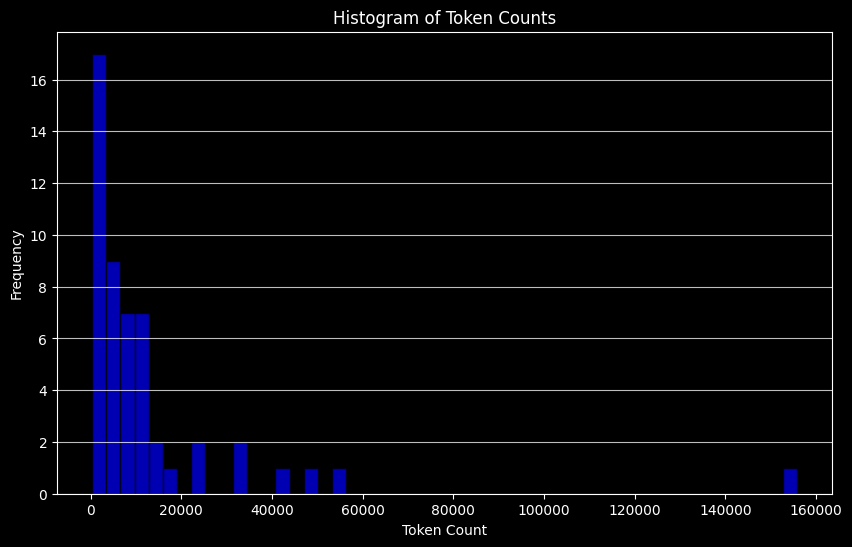

In [11]:
import pickle
with open('C:/Users/Jens/data_sienc_visuel/data2/loaded_xml/seaved_xml.pkl', 
          'rb') as inp:
    docs = pickle.load(inp)
    
docs_texts = [d.page_content for d in docs]

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

plt.figure(figsize=(10, 6))
plt.hist(counts, bins=50, color="blue", edgecolor="black", alpha=0.7)
plt.title("Histogram of Token Counts")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)


plt.show

In [ ]:
for d, c in zip(docs_texts, counts):
    print(f"Text: {d[:50]}... Num Tokens: {c}")

In [ ]:
print(docs_texts[28])

In [ ]:
# Doc texts concat
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))
concatenated_content = "\n\n\n --- \n\n\n".join(
    [doc.page_content for doc in d_reversed]
)
print(concatenated_content)
print(
    "Num tokens in all context: %s"
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)
print(concatenated_content)

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(concatenated_content)
print("Number of chunks = ", len(texts_split))
print(texts_split[0])

In [ ]:
from langchain_community.embeddings import OllamaEmbeddings
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain_community.chat_models import ChatOllama

In [ ]:

llm_name = "mistral:7b-instruct-v0.2-q4_0"
ollama_base_url="http://localhost:11434"



def load_embedding_model(config={}):
    embeddings = SentenceTransformerEmbeddings(
        model_name="all-MiniLM-L12-v2", cache_folder="/embedding_model"
    )
    dimension = 384
    return embeddings, dimension    
def load_llm(llm_name: str, config={}):
    return ChatOllama(
                temperature=0,
                base_url=config["ollama_base_url"],
                model=llm_name,
                streaming=True,
                # seed=2,
                top_k=10,  # A higher value (100) will give more diverse answers, while a lower value (10) will be more conservative.
                top_p=0.3,  # Higher value (0.95) will lead to more diverse text, while a lower value (0.5) will generate more focused text.
                num_ctx=3072,  # Sets the size of the context window used to generate the next token.
            )        

In [ ]:


embd, dimension = load_embedding_model()


model = load_llm(llm_name, config={"ollama_base_url": ollama_base_url})




In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 224

In [ ]:
def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters


### --- Our code below --- ###


def embed(texts):
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    text_embeddings = embd.embed_documents(texts)
    text_embeddings_np = np.array(text_embeddings)
    return text_embeddings_np


def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Here is a sub-set of LangChain Expression Langauge doc. 
    
    LangChain Expression Langauge provides a way to compose chain in LangChain.
    
    Give a detailed summary of the documentation provided.
    
    Documentation:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

In [ ]:
# Build tree
leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(leaf_texts, level=1, n_levels=3)

In [ ]:
leaf_texts

In [ ]:
from langchain_community.vectorstores import Chroma

all_texts = leaf_texts.copy()

for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)
    
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)
retriever = vectorstore.as_retriever()    

In [ ]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# Prompt
prompt = hub.pull("rlm/rag-prompt")


# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

# Question
rag_chain.invoke("hvad er forbudt I perioden fra og med torsdag den 21. marts 2024 til og med onsdag den 10. april 2024? og hvad er begrundelsen for lukningen?")